In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
IMAGE_SIZE = 32
mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]
# source: https://pytorch.org/vision/stable/transforms.html
transforms_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean, std)])


transforms_test = transforms.Compose([transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)])

train_dataset =  datasets.CIFAR10(root='./data', train=True, download=True, transform = transforms_train)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform = transforms_test)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=512, num_workers=31, persistent_workers=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=512, num_workers=31, persistent_workers=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.1308641].


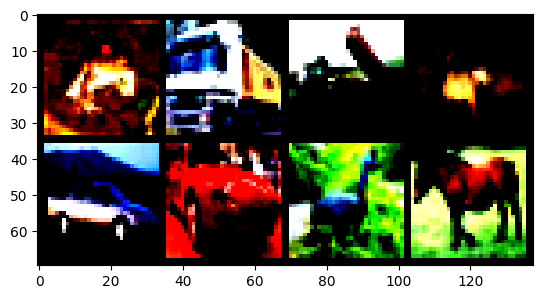

In [4]:
# show some train images
import matplotlib.pyplot as plt
import numpy as np
def show_img(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images, labels = next(iter(train_loader))
show_img(torchvision.utils.make_grid(images[:8], nrow=4, padding=2))

In [4]:
from model_utils import DenseNetLit
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import MLFlowLogger

torch.set_float32_matmul_precision('medium')

In [5]:
class DataModule(L.LightningDataModule):
    def __init__(self, train_loader, validation_loader):
        super().__init__()
        self.train_loader = train_loader
        self.validation_loader = validation_loader

    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.validation_loader
    

data=DataModule(train_loader, validation_loader)
hyperparameters = {
    "depth": 40,
    "first_output": 16,
    "growth_rate": 12,
    "dropout": 0.2,
}
model = DenseNetLit(hyperparameters=hyperparameters)
logger = MLFlowLogger(experiment_name="DenseNet", save_dir="mlruns")
trainer = L.Trainer(max_epochs=150, logger=logger, callbacks=
                    [ModelCheckpoint(monitor="val_f1_macro", mode="max", dirpath="checkpoints/densenet", filename="{epoch:02d}-{val_f1_macro:.3f}-{val_accuracy:.3f}")],
                    precision="16-mixed", 
                    num_sanity_val_steps=0)
trainer.fit(model, datamodule=data)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\SPCX\Desktop\github-repositories\optimization-data-analysis\.venv\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\SPCX\Desktop\github-repositories\optimization-data-analysis\models\checkpoints\densenet exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | DenseNet         | 1.0 M  | train
1 | loss_fn       | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M 

Epoch 149: 100%|██████████| 98/98 [00:32<00:00,  3.04it/s, v_num=62bd]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 98/98 [00:32<00:00,  3.04it/s, v_num=62bd]


At epoch 48 validation f1 macro score is 0.89 while training with max_epochs=50

# Visualization of the training process - 50 epochs

![Learning Rate](../img/lr_epoch.png)
![Train Loss](../img/train_loss_epoch.png)
![Validation Loss](../img/val_loss_epoch.png)

# Visualization of the training process - 150 epochs

![Learning Rate](../img/lr_epoch-150epochs.png)
![Train Loss](../img/train_loss_epoch-150epochs.png)
![Validation Loss](../img/val_loss_epoch-150epochs.png)
![Validation Accuracy](../img/val_accuracy-150epochs.png)